In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


In [ ]:
# Veri setini yükle
#data_path = "/drive/MyDrive/dataset/Breakhis 400X"

In [ ]:
<train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)  # Test verisi için sadece normalizasyon

train_generator = train_datagen.flow_from_directory(
    '/drive/MyDrive/dataset/BreaKHis 400X/train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    '/drive/MyDrive/dataset/BreaKHis 400X/test',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Directory where the images are stored
base_dir = '/drive/MyDrive/dataset/BreaKHis 400X'

# Instantiate the ImageDataGenerator to augment the data
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


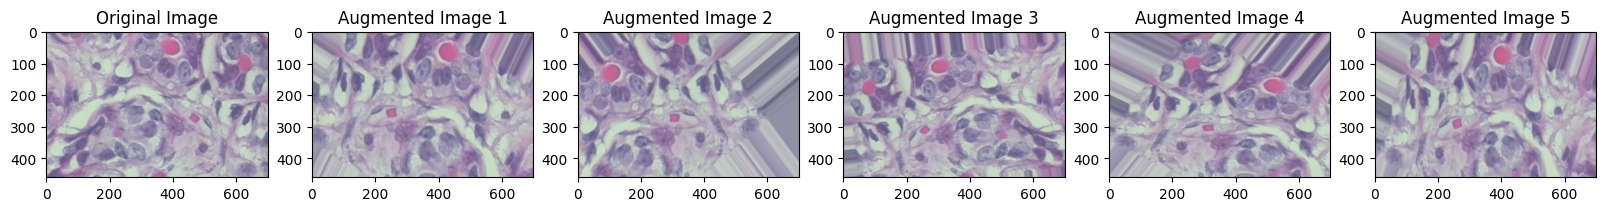

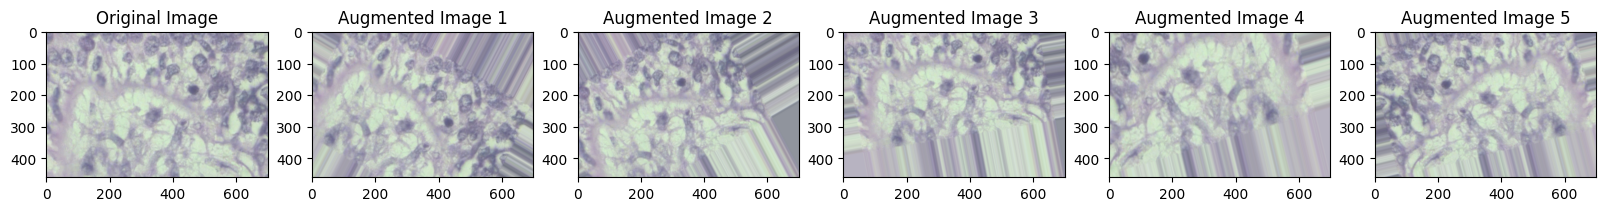

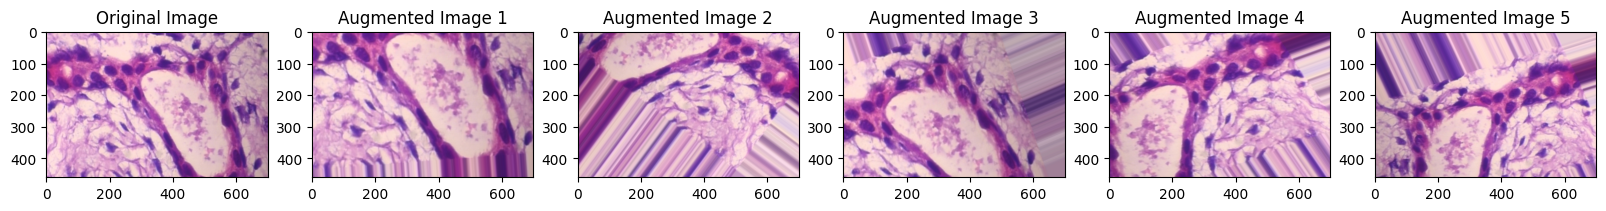

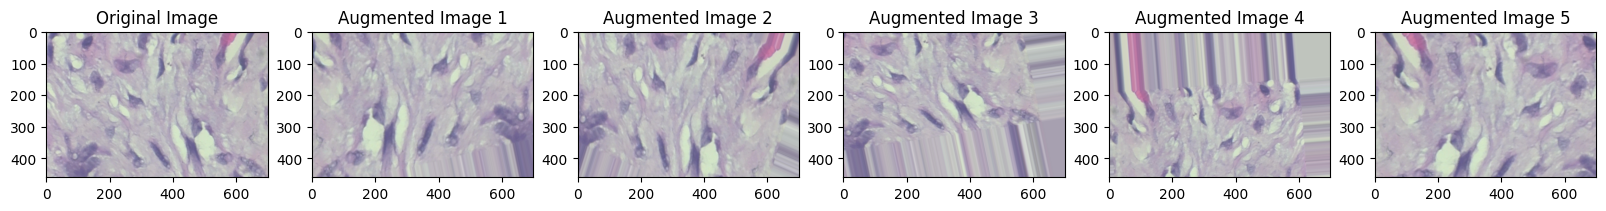

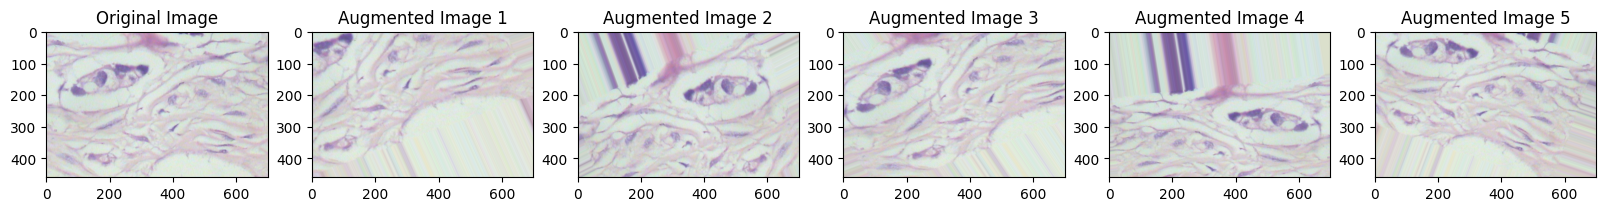

In [ ]:
def load_and_augment_images(dataset_type='train', class_type='benign', num_files=5, num_augmented_images=5):
    # Path to the specific dataset and class type
    target_dir = os.path.join(base_dir, dataset_type, class_type)

    # List all files in the target directory
    all_files = [f for f in os.listdir(target_dir) if os.path.isfile(os.path.join(target_dir, f))]

    # Randomly select a subset of image files
    selected_files = random.sample(all_files, min(num_files, len(all_files)))

    for image_file in selected_files:
        img_path = os.path.join(target_dir, image_file)
        img = load_img(img_path)  # Load image
        x = img_to_array(img)  # Convert to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

        fig, ax = plt.subplots(1, num_augmented_images + 1, figsize=(20, 10))
        ax[0].imshow(img)
        ax[0].set_title('Original Image')

        # Generate and plot augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            ax[i + 1].imshow(np.uint8(batch[0]))
            ax[i + 1].set_title(f'Augmented Image {i + 1}')
            i += 1
            if i >= num_augmented_images:
                break
        plt.show()

# Example usage: Load and augment 5 images from the 'benign' class in the 'train' directory
load_and_augment_images(dataset_type='train', class_type='benign', num_files=5)

In [ ]:
# Load the base VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create custom layers on top of the base model
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# Combine the base and top model
model = Model(inputs=base_model.input, outputs=top_model)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

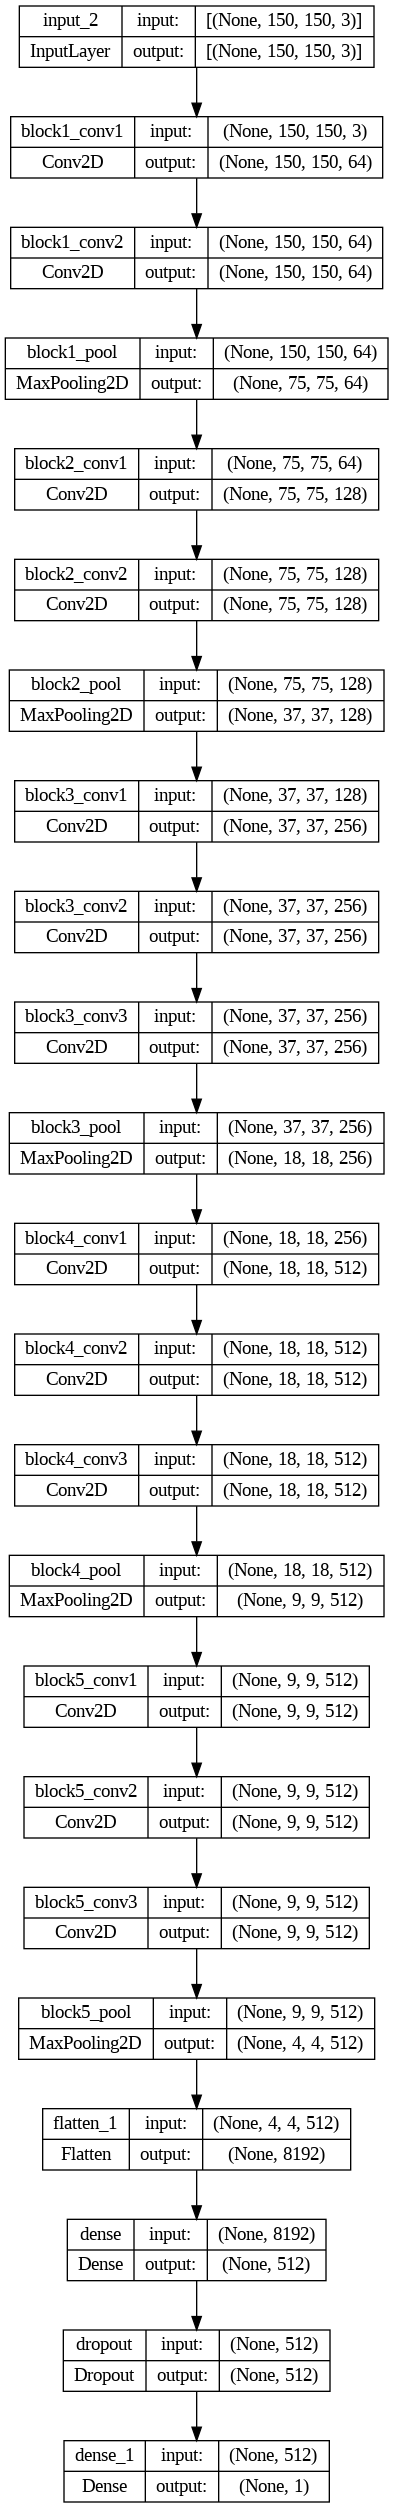

In [ ]:
plot_model(model, to_file='ResNet50_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=20
)

Epoch 1/30
20/20 [==============================] - 380s 19s/step - loss: 1.6048 - accuracy: 0.6225 - val_loss: 1.3926 - val_accuracy: 0.7050
Epoch 2/30
20/20 [==============================] - 255s 13s/step - loss: 1.4008 - accuracy: 0.6675 - val_loss: 1.3721 - val_accuracy: 0.6700
Epoch 3/30
20/20 [==============================] - 287s 14s/step - loss: 1.3195 - accuracy: 0.6875 - val_loss: 1.2475 - val_accuracy: 0.7325
Epoch 4/30
20/20 [==============================] - 223s 11s/step - loss: 1.2830 - accuracy: 0.7113 - val_loss: 1.1678 - val_accuracy: 0.7425
Epoch 5/30
20/20 [==============================] - 256s 13s/step - loss: 1.1496 - accuracy: 0.7450 - val_loss: 1.1381 - val_accuracy: 0.7450
Epoch 6/30
20/20 [==============================] - 255s 13s/step - loss: 1.1276 - accuracy: 0.7575 - val_loss: 1.0867 - val_accuracy: 0.7600
Epoch 7/30
20/20 [==============================] - 255s 13s/step - loss: 1.1147 - accuracy: 0.7375 - val_loss: 1.1011 - val_accuracy: 0.7175
Epoch 

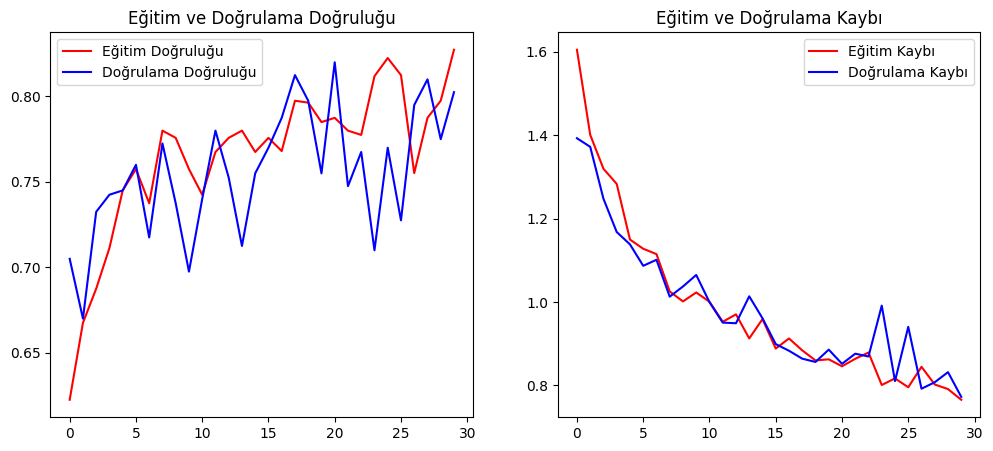

En Yüksek Eğitim Doğruluğu: 0.8273195624351501
En Yüksek Doğrulama Doğruluğu: 0.8199999928474426
En Düşük Eğitim Doğruluğu: 0.7653722167015076
En Düşük Doğrulama Doğruluğu: 0.7723759412765503


In [ ]:
# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Eğitim Doğruluğu')
plt.plot(epochs, val_acc, 'b', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'b', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()

plt.show()

# Print out the highest and lowest metrics
highest_training_accuracy = max(acc)
highest_validation_accuracy = max(val_acc)
lowest_training_loss = min(loss)
lowest_validation_loss = min(val_loss)

print("En Yüksek Eğitim Doğruluğu:", highest_training_accuracy)
print("En Yüksek Doğrulama Doğruluğu:", highest_validation_accuracy)
print("En Düşük Eğitim Doğruluğu:", lowest_training_loss)
print("En Düşük Doğrulama Doğruluğu:", lowest_validation_loss)

28/28 [==============================] - 154s 5s/step
Accuracy (Doğruluk): 0.5798165137614679
Precision (Kesinlik): 0.6627906976744186
Recall (Geri Çağırma): 0.7723577235772358
F1 Score: 0.7133917396745931

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.27      0.18      0.21       176
           1       0.66      0.77      0.71       369

    accuracy                           0.58       545
   macro avg       0.47      0.47      0.46       545
weighted avg       0.54      0.58      0.55       545


Karışıklık Matrisi:
 [[ 31 145]
 [ 84 285]]


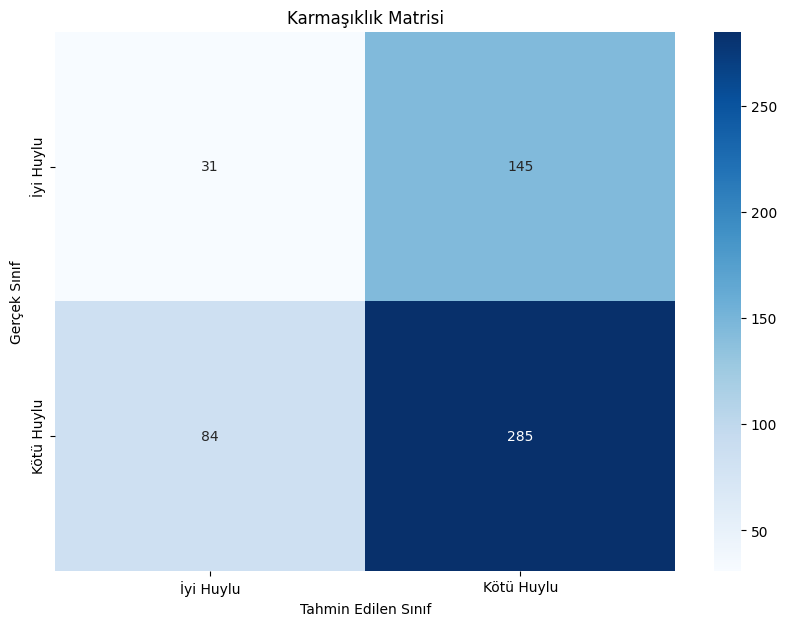

In [ ]:
# Tahminlerin yapılması
validation_generator.reset()
preds = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
preds = np.round(preds).astype(int).reshape(-1)

# Gerçek etiketlerin alınması
true_labels = validation_generator.classes

# Metriklerin hesaplanması
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds)
recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)

print("Accuracy (Doğruluk):", accuracy)
print("Precision (Kesinlik):", precision)
print("Recall (Geri Çağırma):", recall)
print("F1 Score:", f1)

# Ayrıntılı sınıflandırma raporu
print("\nSınıflandırma Raporu:\n", classification_report(true_labels, preds))

# Confusion Matrix (Karmaşıklık Matrisi)
conf_matrix = confusion_matrix(true_labels, preds)
print("\nKarışıklık Matrisi:\n", conf_matrix)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['İyi Huylu', 'Kötü Huylu'], yticklabels=['İyi Huylu', 'Kötü Huylu'])
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()